In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load your dataset from Google Drive
df = pd.read_csv("/content/drive/MyDrive/train.csv")

sampled_df = df.sample(n=5000, random_state=42)

# Save the sampled data to a new file in your Google Drive
sampled_df.to_csv("/content/drive/MyDrive/sampled_dataset.csv", index=False)
dataset=sampled_df
dataset=sampled_df
dataset = dataset.reset_index(drop=True)
dataset=dataset.rename(columns={'document':'text'})
dataset.head()

,text,summary
0,the european commission tuesday fined the germ...,"eu fines lufthansa dlrs ##,### for discriminat..."
1,a total of #.# billion-us dollars of loan assi...,adb to provide #.# billion usd loan assistance...
2,since the bosnian peace deal was signed three ...,getting out foremost on minds of some bosnian ...
3,hundreds of traders have filed a lawsuit again...,zambian hawkers sue government
4,fresh off a fourth straight sellout at wembley...,nfl optimistic of multiple games in britain


In [ ]:
dataset.shape

(5000, 2)

In [ ]:
dataset.isnull().sum()

text       0
summary    0
dtype: int64

In [ ]:
dataset.columns

Index(['text', 'summary'], dtype='object')

In [ ]:
# Find the minimum and maximum text lengths
min_text_length = dataset['text'].str.len().min()
max_text_length = dataset['text'].str.len().max()

# Find the minimum and maximum summary lengths
min_summary_length = dataset['summary'].str.len().min()
max_summary_length = dataset['summary'].str.len().max()

print(f"Minimum Text Length: {min_text_length}")
print(f"Maximum Text Length: {max_text_length}")
print(f"Minimum Summary Length: {min_summary_length}")
print(f"Maximum Summary Length: {max_summary_length}")


Minimum Text Length: 40
Maximum Text Length: 399
Minimum Summary Length: 16
Maximum Summary Length: 124


In [ ]:
!pip install transformers
!pip install SentencePiece
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config, AdamW

In [ ]:
from sklearn.model_selection import train_test_split
X = dataset['text']
y = dataset['summary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000,) (1000,) (4000,) (1000,)


In [ ]:
train_df = pd.concat([X_train,y_train],axis=1, ignore_index=True)
test_df = pd.concat([X_test, y_test],axis=1, ignore_index=True)
train_df= train_df.rename(columns={0:'text',1:'summary'})
test_df= test_df.rename(columns={0:'text',1:'summary'})

In [ ]:
import torch
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
from IPython.display import HTML, display
def progress(loss,value, max=100):
 return HTML(""" Batch loss :{loss}
      <progress
value='{value}'max='{max}',style='width: 100%'>{value}
      </progress>
             """.format(loss=loss,value=value, max=max))

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
batch_size=32
num_of_batches=int(len(X_train)/batch_size)

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-4)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def trainfun(model, train_df, batch_size, num_of_epochs, optimizer):
    model.train()
    num_of_batches = int(len(train_df) / batch_size)
    loss_per_10_steps = []
    for epoch in range(1, num_of_epochs + 1):
        print('Running epoch: {}'.format(epoch))
        running_loss = 0
        out = display(progress(1, num_of_batches + 1), display_id=True)
        for i in range(num_of_batches):
            inputbatch = []
            labelbatch = []
            new_df = train_df[i * batch_size:i * batch_size + batch_size]
            for indx, row in new_df.iterrows():
                input = str(row['text']) + '[SEP]'
                labels = row['summary'] + '[SEP]'
                inputbatch.append(input)
                labelbatch.append(labels)
            inputbatch = tokenizer.batch_encode_plus(inputbatch, padding=True, max_length=512, truncation = True, return_attention_mask = True, add_special_tokens= True, return_tensors='pt')["input_ids"]
            labelbatch = tokenizer.batch_encode_plus(labelbatch, padding=True, max_length=512, truncation = True, return_attention_mask = True, add_special_tokens= True, return_tensors="pt")["input_ids"]
            inputbatch = inputbatch.to(dev)
            labelbatch = labelbatch.to(dev)

            optimizer.zero_grad()

            # Forward propagation
            outputs = model(input_ids=inputbatch, labels=labelbatch)
            loss = outputs.loss
            loss_num = loss.item()
            logits = outputs.logits
            running_loss += loss_num
            if i % 10 == 0:
                loss_per_10_steps.append(loss_num)
                out.update(progress(loss_num, i, num_of_batches + 1))

            # Calculating the gradients
            loss.backward()

            # Updating the parameters
            optimizer.step()

        running_loss = running_loss / int(num_of_batches)
        print('Epoch: {} , Running loss: {}'.format(epoch, running_loss))

    return model, loss_per_10_steps

model, loss_per_10_steps = trainfun(model, train_df, batch_size, 50, optimizer)

Running epoch: 1


Epoch: 1 , Running loss: 1.48771213054657
Running epoch: 2


Epoch: 2 , Running loss: 1.1744098105430603
Running epoch: 3


Epoch: 3 , Running loss: 1.0966482429504394
Running epoch: 4


Epoch: 4 , Running loss: 1.0284192628860473
Running epoch: 5


Epoch: 5 , Running loss: 0.9693990993499756
Running epoch: 6


Epoch: 6 , Running loss: 0.916662338256836
Running epoch: 7


Epoch: 7 , Running loss: 0.8692223734855652
Running epoch: 8


Epoch: 8 , Running loss: 0.828268937587738
Running epoch: 9


Epoch: 9 , Running loss: 0.784283392906189
Running epoch: 10


Epoch: 10 , Running loss: 0.7475545072555542
Running epoch: 11


Epoch: 11 , Running loss: 0.7105847637653351
Running epoch: 12


Epoch: 12 , Running loss: 0.6766941778659821
Running epoch: 13


Epoch: 13 , Running loss: 0.6457807903289795
Running epoch: 14


Epoch: 14 , Running loss: 0.6167990539073944
Running epoch: 15


Epoch: 15 , Running loss: 0.589730316400528
Running epoch: 16


Epoch: 16 , Running loss: 0.5627247579097748
Running epoch: 17


Epoch: 17 , Running loss: 0.5340075261592865
Running epoch: 18


Epoch: 18 , Running loss: 0.5113125452995301
Running epoch: 19


Epoch: 19 , Running loss: 0.48574906635284426
Running epoch: 20


Epoch: 20 , Running loss: 0.461370240688324
Running epoch: 21


Epoch: 21 , Running loss: 0.44107509732246397
Running epoch: 22


Epoch: 22 , Running loss: 0.4233978910446167
Running epoch: 23


Epoch: 23 , Running loss: 0.4018855664730072
Running epoch: 24


Epoch: 24 , Running loss: 0.3894335656166077
Running epoch: 25


Epoch: 25 , Running loss: 0.37118436431884766
Running epoch: 26


Epoch: 26 , Running loss: 0.35679671764373777
Running epoch: 27


Epoch: 27 , Running loss: 0.33843388748168945
Running epoch: 28


Epoch: 28 , Running loss: 0.3205025922060013
Running epoch: 29


Epoch: 29 , Running loss: 0.3043495184183121
Running epoch: 30


Epoch: 30 , Running loss: 0.28854844665527346
Running epoch: 31


Epoch: 31 , Running loss: 0.27615300703048706
Running epoch: 32


Epoch: 32 , Running loss: 0.2609749050140381
Running epoch: 33


Epoch: 33 , Running loss: 0.24907496333122253
Running epoch: 34


Epoch: 34 , Running loss: 0.23354741227626802
Running epoch: 35


Epoch: 35 , Running loss: 0.22643108129501344
Running epoch: 36


Epoch: 36 , Running loss: 0.21317057919502258
Running epoch: 37


Epoch: 37 , Running loss: 0.20363800954818725
Running epoch: 38


Epoch: 38 , Running loss: 0.19378475320339203
Running epoch: 39


Epoch: 39 , Running loss: 0.18464892077445985
Running epoch: 40


Epoch: 40 , Running loss: 0.1742698032259941
Running epoch: 41


Epoch: 41 , Running loss: 0.16299693822860717
Running epoch: 42


Epoch: 42 , Running loss: 0.16115462839603423
Running epoch: 43


Epoch: 43 , Running loss: 0.1528256711959839
Running epoch: 44


Epoch: 44 , Running loss: 0.14485407131910324
Running epoch: 45


Epoch: 45 , Running loss: 0.13829604041576385
Running epoch: 46


Epoch: 46 , Running loss: 0.13203753596544265
Running epoch: 47


Epoch: 47 , Running loss: 0.12664904421567916
Running epoch: 48


Epoch: 48 , Running loss: 0.12140658903121948
Running epoch: 49


Epoch: 49 , Running loss: 0.11555436855554581
Running epoch: 50


Epoch: 50 , Running loss: 0.10857712423801422


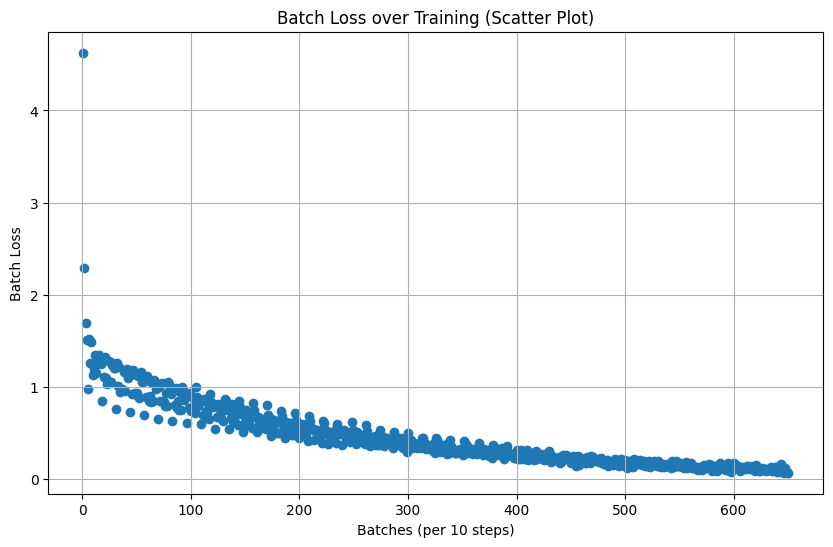

In [ ]:
import matplotlib.pyplot as plt

# Create a list of batch numbers (x-axis)
batch_numbers = list(range(1, len(loss_per_10_steps) + 1))

# Plot a scatter plot of loss per 10 steps
plt.figure(figsize=(10, 6))
plt.scatter(batch_numbers, loss_per_10_steps, marker='o')
plt.xlabel('Batches (per 10 steps)')
plt.ylabel('Batch Loss')
plt.title('Batch Loss over Training (Scatter Plot)')
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "t5_small.pt")

In [ ]:
model_save_dir = "/content/drive/MyDrive/t5_model/model"
tokenizer_save_dir = "/content/drive/MyDrive/t5_model/tokenizer"

# Save the model and tokenizer to their respective directories
model.save_pretrained(model_save_dir)
tokenizer.save_pretrained(tokenizer_save_dir)

In [ ]:
# Create an empty list to store the generated summaries
generated_summaries = []

# Iterate through the text data in test_df
for index, row in test_df.iterrows():
    input_text = row['text']  # Get the text from the 'text' column

    # Tokenize the input text
    input_ids = loaded_tokenizer.encode(input_text, return_tensors="pt")

    # Generate a summary using the loaded model
    summary_ids = loaded_model.generate(
        input_ids,
        max_length=128,  # Set the desired maximum length for the summaries
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = loaded_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Append the generated summary to the list
    generated_summaries.append(summary)

# Add the generated summaries to the test_df
test_df['generated_summary'] = generated_summaries

# View the test_df with the generated summaries
print(test_df[['text', 'generated_summary']])

                                                    text  \
15424  two intoxicated young people in a small villag...   
963    tillakaratne dilshan scored a hundred and put ...   
3616   santiago silva scored twice as velez beat godo...   
13103  a four-member delegation from the ghana footba...   
8099   germany 's biggest tourism group tui posted a ...   
...                                                  ...   
7515   trying to prevent the kind of brinkmanship tha...   
2512   the hushen ### index reflecting the performanc...   
8507   boeing co. has snagged enough firm orders and ...   
7101   here is a summary of the races for the u.s. ho...   
13400  the idea of holding private sales of premium m...   

                                       generated_summary  
15424       ukraine teen kills food guard pensioner[St.]  
963      dilshan leads sri lanka to ###-# at stumps[St.]  
3616   santiago silva stays in argentina apertura rac...  
13103  ghana football ministry to meet fifa

In [ ]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=3ec71fc1e794250cfa638f35a48c97f9dc958a02cd72b248c17c6de32810c31f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
test_df_review_summary = test_df["summary"].tolist()
test_df_predicted = test_df['generated_summary'].tolist()

In [ ]:
similarity_scores = []
for rs_text, p_text in zip(test_df_review_summary, test_df_predicted):
    rs_embedding = model.encode(rs_text)
    p_embedding = model.encode(p_text)
    similarity = np.inner(rs_embedding, p_embedding)
    similarity_scores.append(similarity)

In [ ]:
# Printing the similarity scores for each pair
for i, similarity_score in enumerate(similarity_scores):
    print(f"Similarity between 'actual_summary {i+1}' and its 'predicted_summary': {similarity_score:.4f}")

Similarity between 'actual_summary 1' and its 'predicted_summary': 0.4542
Similarity between 'actual_summary 2' and its 'predicted_summary': 0.6082
Similarity between 'actual_summary 3' and its 'predicted_summary': 0.5586
Similarity between 'actual_summary 4' and its 'predicted_summary': 0.8076
Similarity between 'actual_summary 5' and its 'predicted_summary': 0.7514
Similarity between 'actual_summary 6' and its 'predicted_summary': 0.7867
Similarity between 'actual_summary 7' and its 'predicted_summary': 0.8001
Similarity between 'actual_summary 8' and its 'predicted_summary': 0.8181
Similarity between 'actual_summary 9' and its 'predicted_summary': 0.7644
Similarity between 'actual_summary 10' and its 'predicted_summary': 0.8834
Similarity between 'actual_summary 11' and its 'predicted_summary': 0.2788
Similarity between 'actual_summary 12' and its 'predicted_summary': 0.8043
Similarity between 'actual_summary 13' and its 'predicted_summary': 0.7792
Similarity between 'actual_summary

In [ ]:
average_similarity = np.mean(similarity_scores)

#average similarity score
print(f'Average Cosine Similarity Score: {average_similarity:.4f}')

Average Cosine Similarity Score: 0.6609


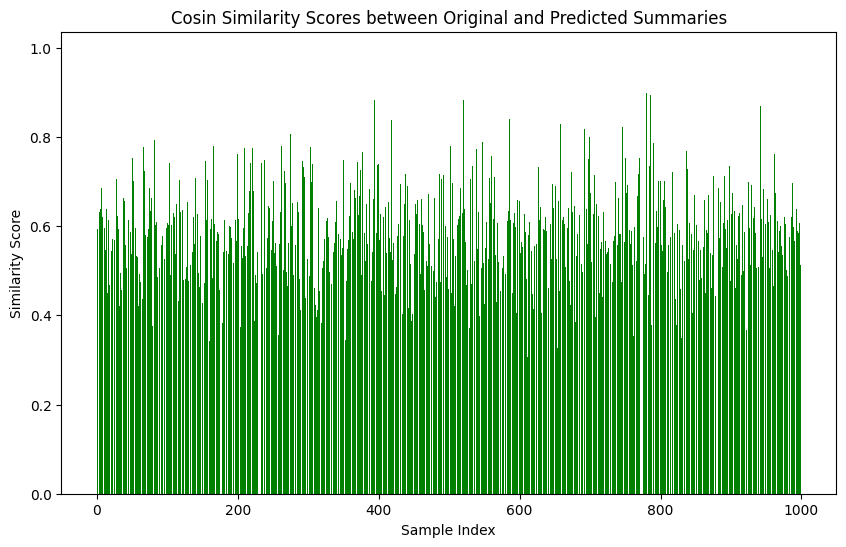

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores)), similarity_scores,color='g')
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Cosin Similarity Scores between Original and Predicted Summaries')
plt.show()

In [ ]:
pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from bert_score import score

# Load the SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  # Choose an appropriate model

# Initialize the dataframes with your data
# Replace 'your_review_summary_data' and 'your_predicted_data' with your actual data
test_df_review_summary = test_df["summary"].tolist()
test_df_predicted = test_df['generated_summary'].tolist()

# Initialize a list to store the similarity scores
similarity_scores = []

# Define a minimum_length_threshold (e.g., 5 words)
minimum_length_threshold = 5

# Calculate BERT-based similarity scores
for rs_text, p_text in zip(test_df_review_summary, test_df_predicted):
    # Check if the reference sentence meets the minimum length threshold
    if len(rs_text.split()) >= minimum_length_threshold:
        # Calculate BERT-based similarity scores using bert_score
        _, _, similarity = score([rs_text], [p_text], lang="en", model_type="bert-base-uncased")
        similarity_scores.append(similarity.item())
    else:
        # Handle cases where the reference sentence is too short
        similarity_scores.append(0.0)  # Set the similarity score to 0

# Print the BERT-based similarity scores
for i, similarity_score in enumerate(similarity_scores):
    print(f"BERT Similarity between 'actual_summary {i+1}' and its 'predicted_summary': {similarity_score:.4f}")

BERT Similarity between 'actual_summary 1' and its 'predicted_summary': 0.4732
BERT Similarity between 'actual_summary 2' and its 'predicted_summary': 0.5934
BERT Similarity between 'actual_summary 3' and its 'predicted_summary': 0.5782
BERT Similarity between 'actual_summary 4' and its 'predicted_summary': 0.5755
BERT Similarity between 'actual_summary 5' and its 'predicted_summary': 0.6319
BERT Similarity between 'actual_summary 6' and its 'predicted_summary': 0.6384
BERT Similarity between 'actual_summary 7' and its 'predicted_summary': 0.6164
BERT Similarity between 'actual_summary 8' and its 'predicted_summary': 0.6849
BERT Similarity between 'actual_summary 9' and its 'predicted_summary': 0.6198
BERT Similarity between 'actual_summary 10' and its 'predicted_summary': 0.7316
BERT Similarity between 'actual_summary 11' and its 'predicted_summary': 0.3916
BERT Similarity between 'actual_summary 12' and its 'predicted_summary': 0.5954
BERT Similarity between 'actual_summary 13' and i

In [ ]:
average_similarity = np.mean(similarity_scores)

#average similarity score
print(f'Average Bert Similarity Score: {average_similarity:.4f}')

Average Bert Similarity Score: 0.5651


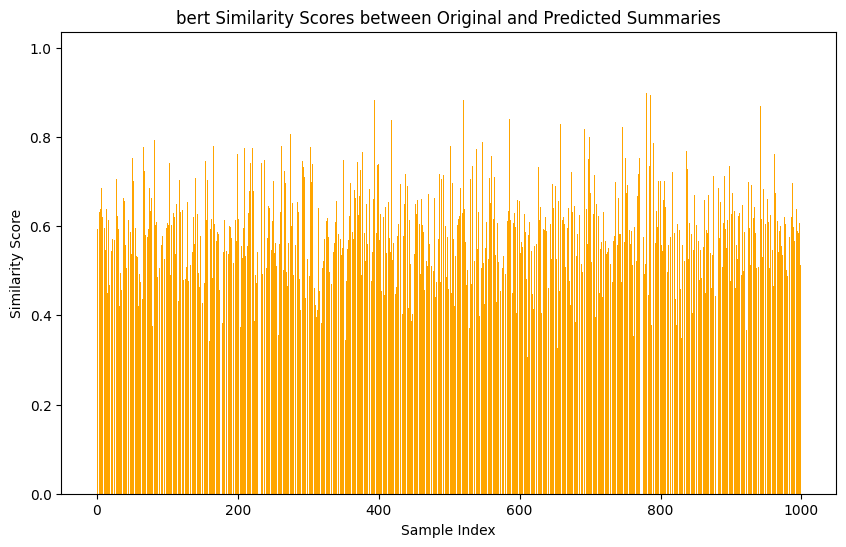

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarity_scores)), similarity_scores,color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('bert Similarity Scores between Original and Predicted Summaries')
plt.show()

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
from tabulate import tabulate

# Initialize the Rouge object
rouge = Rouge()

# Create lists to store ROUGE scores for rows where any ROUGE-1 score is greater than 0.5
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []

# Create a list to store the ROUGE scores as lists for individual rows
table_data = []

# Iterate through each row in your data frame
for index, row in test_df.iterrows():
    # Get the reference summary and system-generated summary for the current row
    reference_summary = row['summary']
    system_generated_summary = row['generated_summary']

    # Calculate ROUGE scores for the current row
    row_scores = rouge.get_scores(system_generated_summary, reference_summary)[0]  # [0] because get_scores returns a list

    # Check if any ROUGE-1 score is greater than 0.5
    if any(score > 0.5 for score in row_scores['rouge-1'].values()):
        # Append ROUGE scores for this row to the respective lists
        rouge_1_scores.append(row_scores['rouge-1'])
        rouge_2_scores.append(row_scores['rouge-2'])
        rouge_l_scores.append(row_scores['rouge-l'])

    # Append the scores to the table_data list
    table_data.append([index + 1, row_scores['rouge-1']['r'], row_scores['rouge-1']['p'], row_scores['rouge-1']['f']])

# Calculate average ROUGE scores
avg_rouge_1 = {
    metric: sum(scores[metric] for scores in rouge_1_scores) / len(rouge_1_scores)
    for metric in rouge_1_scores[0].keys()
}

avg_rouge_2 = {
    metric: sum(scores[metric] for scores in rouge_2_scores) / len(rouge_2_scores)
    for metric in rouge_2_scores[0].keys()
}

avg_rouge_l = {
    metric: sum(scores[metric] for scores in rouge_l_scores) / len(rouge_l_scores)
    for metric in rouge_l_scores[0].keys()
}

# Create a header for the table
header = ["Row", "ROUGE-1 Recall (R)", "ROUGE-1 Precision (P)", "ROUGE-1 F1-Score (F)"]

# Print the table
print("Individual ROUGE Scores:")
print(tabulate(table_data, headers=header, tablefmt="grid"))

# Print the average ROUGE scores
print("\nAverage ROUGE-1 Scores:")
print(avg_rouge_1)
print("Average ROUGE-2 Scores:")
print(avg_rouge_2)
print("Average ROUGE-L Scores:")
print(avg_rouge_l)


Individual ROUGE Scores:
+-------+----------------------+-------------------------+------------------------+
|   Row |   ROUGE-1 Recall (R) |   ROUGE-1 Precision (P) |   ROUGE-1 F1-Score (F) |
+=======+======================+=========================+========================+
| 15425 |            0         |               0         |              0         |
+-------+----------------------+-------------------------+------------------------+
|   964 |            0.181818  |               0.222222  |              0.2       |
+-------+----------------------+-------------------------+------------------------+
|  3617 |            0.571429  |               0.333333  |              0.421053  |
+-------+----------------------+-------------------------+------------------------+
| 13104 |            0.333333  |               0.3       |              0.315789  |
+-------+----------------------+-------------------------+------------------------+
|  8100 |            0.375     |               0.18

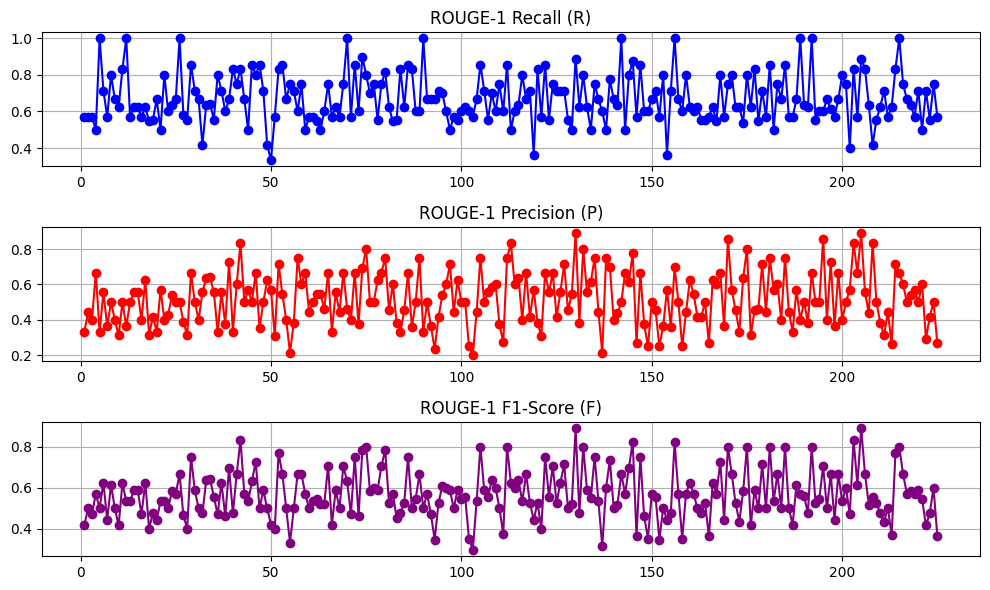

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store R, P, and F scores
recall_scores = []
precision_scores = []
f1_scores = []

# Iterate through each row in your data frame
for index, row in test_df.iterrows():
    # Get the reference summary and system-generated summary for the current row
    reference_summary = row['summary']
    system_generated_summary = row['generated_summary']

    # Calculate ROUGE scores for the current row
    row_scores = rouge.get_scores(system_generated_summary, reference_summary)[0]  # [0] because get_scores returns a list

    # Check if any ROUGE score (R, P, or F) is greater than 0.5
    if any(score > 0.5 for score in row_scores['rouge-1'].values()):
        # Append R, P, and F scores to their respective lists
        recall_scores.append(row_scores['rouge-1']['r'])
        precision_scores.append(row_scores['rouge-1']['p'])
        f1_scores.append(row_scores['rouge-1']['f'])

# Create a list of batch numbers (x-axis)
batch_numbers = list(range(1, len(recall_scores) + 1))

# Plot separate graphs for R, P, and F scores
plt.figure(figsize=(10, 6))

# Plot ROUGE-1 Recall (R)
plt.subplot(3, 1, 1)
plt.plot(batch_numbers, recall_scores, marker='o', linestyle='-',color='b')
plt.title('ROUGE-1 Recall (R)')
plt.grid(True)

# Plot ROUGE-1 Precision (P)
plt.subplot(3, 1, 2)
plt.plot(batch_numbers, precision_scores, marker='o', linestyle='-',color='r')
plt.title('ROUGE-1 Precision (P)')
plt.grid(True)

# Plot ROUGE-1 F1-Score (F)
plt.subplot(3, 1, 3)
plt.plot(batch_numbers, f1_scores, marker='o', linestyle='-',color='purple')
plt.title('ROUGE-1 F1-Score (F)')
plt.grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
!pip install transformers
!pip install sentencepiece

In [3]:
import ipywidgets as widgets
from IPython.display import display, HTML
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Define the directory where the model is saved
model_load_dir = "/content/drive/MyDrive/t5_model/model"
tokenizer_load_dir = "/content/drive/MyDrive/t5_model/tokenizer"

# Load the model and tokenizer
loaded_model = T5ForConditionalGeneration.from_pretrained(model_load_dir)
loaded_tokenizer = T5Tokenizer.from_pretrained(tokenizer_load_dir)

# Define a minimum length threshold
min_length_threshold = 10  # Adjust this threshold based on your requirements

def generate_summary(btn):
    user_input = input_text.value

    # Check if input is too short
    if len(user_input.split()) < min_length_threshold:
        summary_output.value = "Input text is too short for summarization."
        return

    # Continue with the summarization process
    # Tokenize the input
    input_ids = loaded_tokenizer.encode(user_input, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    summary_ids = loaded_model.generate(input_ids, max_length=400, num_beams=2, length_penalty=1.5, early_stopping=True)
    generated_summary = loaded_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Display the summary
    summary_output.value = generated_summary

# Create the input Text widget with a heading
input_heading = widgets.HTML("<h2 style='color: #4682B4;'>Input Text:</h2>")
input_text = widgets.Textarea(
    value='',
    placeholder='Enter text here',
    disabled=False,
    layout=widgets.Layout(width='45%', height='200px')
)

# Create the button
generate_button = widgets.Button(description="Generate Summary", style={'button_color': 'green'})
generate_button.on_click(generate_summary)

# Create the output Text widget with a heading
summary_heading = widgets.HTML("<h2 style='color: #4682B4;'>Generated Summary:</h2>")
summary_output = widgets.Textarea(
    value='',
    placeholder='Generated summary will be displayed here',
    disabled=True,
    layout=widgets.Layout(width='45%', height='150px')
)

# Display widgets with headings and styling
display(widgets.VBox([input_heading, input_text, generate_button, summary_heading, summary_output]))


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Define a minimum length threshold
min_length_threshold = 10  # Adjust this threshold based on your requirements

def generate_summary(btn):
    user_input = input_text.value

    # Check if input is too short
    if len(user_input.split()) < min_length_threshold:
        summary_output.value = "Input text is too short for summarization."
        return

    # Continue with the summarization process
    # Tokenize the input
    input_ids = tokenizer.encode(user_input, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    summary_ids = model.generate(input_ids, max_length=200, num_beams=2, length_penalty=1.5, early_stopping=True)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Display the summary
    summary_output.value = generated_summary

# Create the input Text widget
input_text = widgets.Textarea(
    value='',
    placeholder='Enter text here',
    description='Input:',
    disabled=False,
    layout=widgets.Layout(width='70%', height='200px')
)

# Create the button
generate_button = widgets.Button(description="Generate Summary", style={'button_color': 'lightblue'})
generate_button.on_click(generate_summary)

# Create the output Text widget with increased height and width
summary_output = widgets.Textarea(
    value='',
    placeholder='Generated summary will be displayed here',
    description='Summary:',
    disabled=True,
    layout=widgets.Layout(width='70%', height='150px')
)

# Display widgets
display(input_text, generate_button, HTML("<style>.widget-label { background-color: #F0FFF0; color: black; }</style>"), summary_output, HTML("<style>.widget-label { background-color: #FFFACD; color: black; }</style>"))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Textarea(value='', description='Input:', layout=Layout(height='200px', width='70%'), placeholder='Enter text h…

Button(description='Generate Summary', style=ButtonStyle(button_color='lightblue'))

Textarea(value='', description='Summary:', disabled=True, layout=Layout(height='150px', width='70%'), placehol…